In [1]:
import xarray as xr
import pandas as pd
import pop_tools
import numpy as np
import cftime
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from datetime import datetime
import glob
import flox

# Spinning up a Dask cluster

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='4:00:00')

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/eromashkova/miniconda3/envs/diag-sandbox-moc-pop-tools/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/eromashkova/miniconda3/envs/diag-sandbox-moc-pop-tools/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:35403,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Reading in SAU catch data

In [5]:
df = pd.read_csv('data/SAUP_LME_Catch_annual_newF.csv')

true_catch = df.set_index(["Year", "LMEID"]).to_xarray()

true_catch

### units on catch variables are g wet weight m-2 per year

<xarray.Dataset>
Dimensions:  (Year: 61, LMEID: 65)
Coordinates:
  * Year     (Year) int64 1950 1951 1952 1953 1954 ... 2006 2007 2008 2009 2010
  * LMEID    (LMEID) int64 1 2 3 4 5 6 7 8 9 10 ... 57 58 59 60 61 62 63 65 66
Data variables:
    FwCatch  (Year, LMEID) float64 26.91 154.4 5.209e+03 0.0 ... 63.51 202.2 0.0
    PwCatch  (Year, LMEID) float64 5.118e+04 3.992e+05 ... 4.185e+04 0.008851
    DwCatch  (Year, LMEID) float64 2.473e+04 2.227e+05 ... 8.225e+05 9.241

# Reading in modeled FEISTY data

In [6]:
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/feisty/FEISTY_monthly_002branch.nc'

ds = xr.open_dataset(path)

ds

<xarray.Dataset>
Dimensions:     (time: 768, group: 9, nlat: 384, nlon: 320, fish: 8)
Coordinates:
  * time        (time) object 1958-01-31 00:00:00 ... 2021-12-31 00:00:00
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Data variables:
    biomass     (time, group, nlat, nlon) float64 ...
    fish_yield  (time, fish, nlat, nlon) float64 ...
    production  (time, fish, nlat, nlon) float64 ...

In [7]:
### monthly to annual reweighting from https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/

def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    
    # Setup our masking for nan values
    cond = ds.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (ds * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones*wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [8]:
ds = weighted_temporal_mean(ds)

In [9]:
ds

<xarray.Dataset>
Dimensions:     (fish: 8, group: 9, nlat: 384, nlon: 320, time: 64)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time        (time) object 1958-01-01 00:00:00 ... 2021-01-01 00:00:00
Data variables:
    biomass     (time, group, nlat, nlon) float64 nan nan nan ... nan nan nan
    fish_yield  (time, fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    production  (time, fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan

# Resampling data by LMEs

## Reading in 1 degree LME mask

In [10]:
coords_dict = {'nlat': ds.nlat.data, 'nlon': ds.nlon.data}

In [12]:
ds_lme_x1 = xr.open_dataset("data/LME-mask-POP_gx1v6.nc").assign_coords(coords_dict)
ds_lme_x1 

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320)
Coordinates:
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
  * nlat      (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon      (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Data variables:
    lme_mask  (nlat, nlon) float64 ...
    KMT       (nlat, nlon) int32 ...
    TAREA     (nlat, nlon) float64 ...
Attributes:
    regrid_method:  nearest_s2d

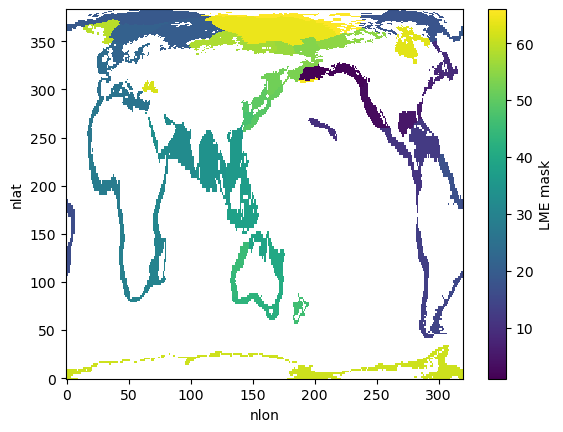

In [13]:
ds_lme_x1.lme_mask.plot()

## Reading in grid variables

In [14]:
ds_grid = pop_tools.get_grid('POP_gx1v6').assign_coords(coords_dict)
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4 # Converting area unit to m^2 (from cm^2)

## Getting list of all LME indices (removing 64, which doesn't have SAU data)

In [15]:
all_lmes = list(np.arange(1,67))
all_lmes.remove(64)
print(all_lmes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66]


## Creating an empty dataset for the modeled catch

In [16]:
modeled_catch = xr.Dataset(coords={"Year": ("Year", np.arange(1980, 2022)),
                "LMEID": ("LMEID", true_catch.LMEID.data)}, 
                           data_vars={'FwCatch': (["Year", "LMEID"], np.zeros((42,65))),
                                      'PwCatch': (["Year", "LMEID"], np.zeros((42,65))),
                                      'DwCatch': (["Year", "LMEID"], np.zeros((42,65)))
                                     })

In [17]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon')).assign_coords(coords_dict)
ones = ones.where(ds_grid.REGION_MASK>0, 0)


for lme in all_lmes[:]:
    print('lme = ', lme)
        
    # Setting up LME masking
    mask_x1 = ones.where(ds_lme_x1.lme_mask == lme)
    masked_area_x1 = area_m.where(ds_lme_x1.lme_mask == lme)
    print('summing area')
    tot_masked_area_x1 = masked_area_x1.sum(dim=('nlon','nlat'))
    print(tot_masked_area_x1.values)
    
    masked_var = ds["fish_yield"].where(mask_x1==1)
    
    masked_var = masked_var.where(masked_var < 0.5)
    masked_var = masked_var.where(masked_var > -0.001)
    print('summing masked var')
    tot_masked_var = (masked_var * masked_area_x1).sum(dim=('nlon','nlat'))
    print('dividing by area')
    ds_tmp =  tot_masked_var / tot_masked_area_x1
    
    for year in np.arange(1980, 2022):
        print(year)
        
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
                
        total_forage = 0
        total_pelagic = 0
        total_demersal = 0
        
        for fish_type in ["Sf", "Mf"]:
            total_forage += float(ds_tmp.sel(fish=fish_type).sel(time=str(year)))
        for fish_type in ["Sp", "Mp", "Lp"]:
            total_pelagic += float(ds_tmp.sel(fish=fish_type).sel(time=str(year)))
        for fish_type in ["Sd", "Md", "Ld"]:
            total_demersal += float(ds_tmp.sel(fish=fish_type).sel(time=str(year)))
            
        print(total_forage)
        print(total_pelagic)
        print(total_demersal)

 
        modeled_catch.FwCatch.loc[dict(Year=year, LMEID=lme)] = total_forage
        modeled_catch.PwCatch.loc[dict(Year=year, LMEID=lme)] = total_pelagic
        modeled_catch.DwCatch.loc[dict(Year=year, LMEID=lme)] = total_demersal
        
    modeled_catch.sel(LMEID=lme).to_zarr(store="data/FEISTY_SAU_comparison_x1/modeled_catch_by_lme_" + str(lme) + ".zarr")
                  

lme =  1
summing area
1288452871987.245
summing masked var
dividing by area
1980
Current Time = 16:47:23
0.0033287600319448743
0.0018293978763902561
0.004226412671184291
1981
Current Time = 16:47:23
0.0031895192318666388
0.001808569627457887
0.004342088011391557
1982
Current Time = 16:47:23
0.0030985193486324854
0.001790372088324828
0.004295796717986205
1983
Current Time = 16:47:23
0.0029798314061074407
0.0017553823715866386
0.004151013404142519
1984
Current Time = 16:47:23
0.0029377716106859914
0.0017296345147570793
0.004025075966624111
1985
Current Time = 16:47:23
0.002854399178252487
0.001703566162361562
0.003895881879210802
1986
Current Time = 16:47:23
0.002950901237761656
0.0016884713706752617
0.0038366810884623175
1987
Current Time = 16:47:23
0.0030883408207933835
0.0017050220092521412
0.003925300764197016
1988
Current Time = 16:47:23
0.003084992775767061
0.0017212100903405611
0.003961599885272813
1989
Current Time = 16:47:23
0.003031148195557399
0.0017184750497671922
0.003985976

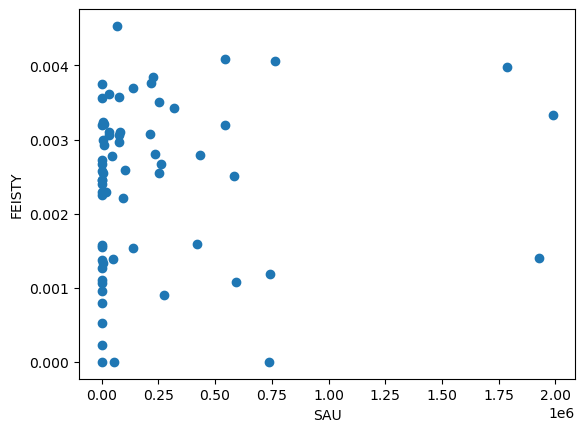

In [18]:
fig, ax = plt.subplots()
plt.scatter(true_catch.FwCatch.sel(Year=1981), modeled_catch.FwCatch.sel(Year=1981))
plt.xlabel("SAU")
plt.ylabel("FEISTY")

plt.show()